In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import shutil
import string
import tensorflow as tf
import re
import gc
import os

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gc.enable()

Num GPUs Available:  1


In [41]:
df = pd.read_csv('reviews_labeled.csv')


In [42]:
print(df)


                                                      text  label
0        if you decide to eat here, just be aware it is...      1
1        family diner. had the buffet. eclectic assortm...      1
2        wow!  yummy, different,  delicious.   our favo...      1
3        cute interior and owner (?) gave us tour of up...      1
4        i am a long term frequent customer of this est...      0
...                                                    ...    ...
4724466  don't misinterpret my 5-star review....i don't...      1
4724467  it is very rare for a restaurant to be this go...      1
4724468  good, maybe very good.  i went for lunch, so t...      1
4724469  for when i'm feeling like ignoring my calorie-...      1
4724470  located in the 'walking district' in nashville...      1

[4724471 rows x 2 columns]


Text(0.5, 0, 'Review Stars')

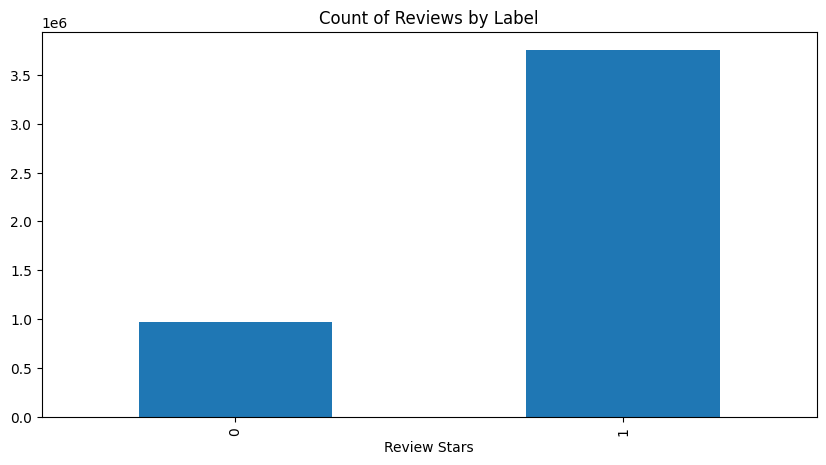

In [43]:
ax = df['label'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Label', figsize=(10, 5))
ax.set_xlabel('Review Stars')

In [5]:
neg_text = df.loc[df.label == 0, ['text', 'label']]
pos_text = df.loc[df.label == 1, ['text', 'label']]
del df
# neg_text.head()


In [6]:
tn = neg_text.sample(n=600000, axis=0)
tp = pos_text.sample(n=600000, axis=0)
equal_base = pd.concat([tn,tp])
del tn
del tp
tensor_dict_from_sample = tf.data.Dataset.from_tensor_slices((dict(equal_base)))


In [7]:
# print(equal_base.shape)
# print(equal_base)


Data sampled to guarantee proper distribution of negative and positive reviews.
Next step: Create tensors and data subsets directly in tensors to be used in the model.

In [8]:
print(tensor_dict_from_sample)
sample_data = tensor_dict_from_sample.shuffle(1200000)
text_array = []
label_array = []
for row in sample_data.take(-1):
  text_array.append(row['text'].numpy())
  label_array.append(row['label'].numpy())

del sample_data
# print(text_array[:2])
# print(label_array[:2]) 

<TensorSliceDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [9]:
base_text_tensor = tf.convert_to_tensor(text_array)
base_label_tensor = tf.convert_to_tensor(label_array)

# print(base_text_tensor)

In [16]:
def create_model_data():

    train_text, test_text, val_text = tf.split(base_text_tensor, [600000, 480000, 120000])
    train_label, test_label, val_label = tf.split(base_label_tensor, [600000, 480000, 120000])
    # print(test_label[352348])
    # print(test_text[352348])
    train_data = tf.data.Dataset.from_tensor_slices((train_text, train_label)).batch(32)
    test_data = tf.data.Dataset.from_tensor_slices((test_text, test_label)).batch(32)
    val_data = tf.data.Dataset.from_tensor_slices((val_text, val_label)).batch(32)
    return (train_data, test_data, val_data, train_text)

train_data, test_data, val_data, train_text = create_model_data()


In [17]:
# val_set = []

# for row in val_label.take(-1):
#     val_set.append(row)

In [18]:
# for row in val_label.take(1):
#     print(row)
# for lrow in val_text.take(1):
#     print(lrow)

In [19]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [20]:
max_features = 20000
sequence_length = 500

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [21]:
# Make a text-only dataset (without labels), then call adapt
vectorize_layer.adapt(train_text)

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [23]:
# retrieve a batch (of 32 reviews and labels) from the dataset
# text_batch = next(iter(train_text))
# label_batch = next(iter(train_label))
# first_review, first_label = text_batch[0], label_batch[0]
# print("Review", first_review)
# print("Label", first_label)
# print("Vectorized review", vectorize_text(first_review, first_label))
# text_batch, label_batch = next(iter(train_data))
# first_review, first_label = text_batch[0], label_batch[0]
# print("Review", first_review)
# print("Label", train_data.class_names[first_label])
# print("Vectorized review", vectorize_text(first_review, first_label))

In [24]:
# print("1287 ---> ",vectorize_layer.get_vocabulary(include_special_tokens=False)[1287])
# print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [25]:
train_ds = train_data.map(vectorize_text)
val_ds = val_data.map(vectorize_text)
test_ds = test_data.map(vectorize_text)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
embedding_dim = 16

In [28]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
__________________________________________________

In [29]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [30]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [31]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
18750/18750 [==============================] - 159s 8ms/step - loss: 0.3112 - binary_accuracy: 0.8856 - val_loss: 0.2316 - val_binary_accuracy: 0.9178
Epoch 2/10
18750/18750 [==============================] - 149s 8ms/step - loss: 0.2294 - binary_accuracy: 0.9201 - val_loss: 0.2220 - val_binary_accuracy: 0.9222
Epoch 3/10
18750/18750 [==============================] - 147s 8ms/step - loss: 0.2214 - binary_accuracy: 0.9230 - val_loss: 0.2195 - val_binary_accuracy: 0.9236
Epoch 4/10
18750/18750 [==============================] - 147s 8ms/step - loss: 0.2178 - binary_accuracy: 0.9244 - val_loss: 0.2186 - val_binary_accuracy: 0.9241
Epoch 5/10
18750/18750 [==============================] - 147s 8ms/step - loss: 0.2153 - binary_accuracy: 0.9254 - val_loss: 0.2184 - val_binary_accuracy: 0.9245
Epoch 6/10
18750/18750 [==============================] - 147s 8ms/step - loss: 0.2137 - binary_accuracy: 0.9259 - val_loss: 0.2183 - val_binary_accuracy: 0.9243
Epoch 7/10
18750/18750 [====

In [32]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

15000/15000 [==============================] - 61s 4ms/step - loss: 0.2201 - binary_accuracy: 0.9249
Loss:  0.22006462514400482
Accuracy:  0.9249187707901001


In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [34]:
gc.collect()

892

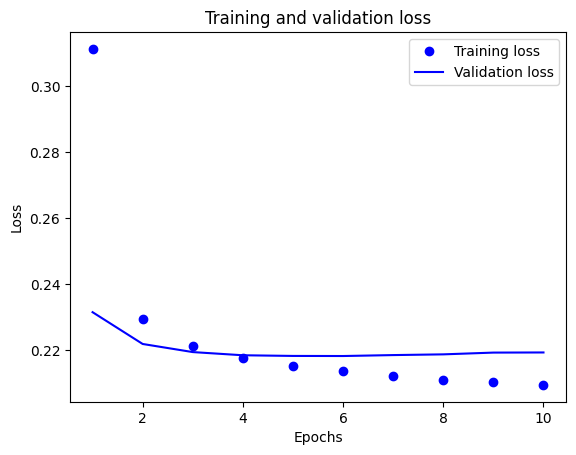

In [35]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

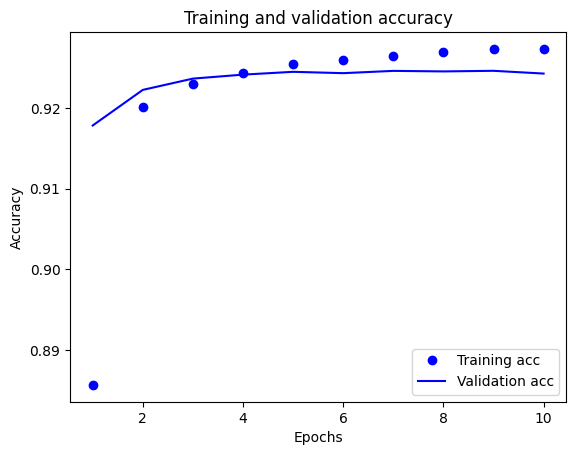

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.show()

In [37]:
def create_model():
    export_model = tf.keras.Sequential([
      vectorize_layer,
      model,
      layers.Activation('sigmoid')
    ])

    export_model.compile(
        loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
    )
    return export_model

export_model = create_model()
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test_data)
print(accuracy)

15000/15000 [==============================] - 94s 6ms/step - loss: 0.2201 - accuracy: 0.9249
0.9249187707901001


In [38]:
# export_model = create_model()
export_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 sequential (Sequential)     (None, 1)                 320033    
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [39]:
examples = [
  "The burger was great!",
  "The pizza was okay.",
  "The soup was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 123ms/step


array([[0.67512214],
       [0.45595306],
       [0.18369424]], dtype=float32)